# Simple Tensorflow Model Using time series data
Credit to this medium post: https://medium.com/analytics-vidhya/sequence-model-time-series-prediction-using-tensorflow-2-0-665257beb25f

In [3]:
import tensorflow as tf
import numpy as np
import csv
import matplotlib.pyplot as plt
tf.__version__

2024-05-23 12:30:29.075374: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 12:30:29.121952: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 12:30:29.936338: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.13.1'

In [4]:
import tensorflow as tf

In [5]:
# Download the CSV file using wget
!wget --no-check-certificate https://raw.githubusercontent.com/satishnaidu/mldata/master/timeseries/USD_INR.csv -O /tmp/USD_INR.csv

# Define the file path
file_path = '/tmp/USD_INR.csv'


--2024-05-23 12:30:40--  https://raw.githubusercontent.com/satishnaidu/mldata/master/timeseries/USD_INR.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130380 (127K) [text/plain]
Saving to: '/tmp/USD_INR.csv'

/tmp/USD_INR.csv    100%[===================>] 127.32K  --.-KB/s    in 0.006s  

2024-05-23 12:30:40 (22.6 MB/s) - '/tmp/USD_INR.csv' saved [130380/130380]



In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

71.515


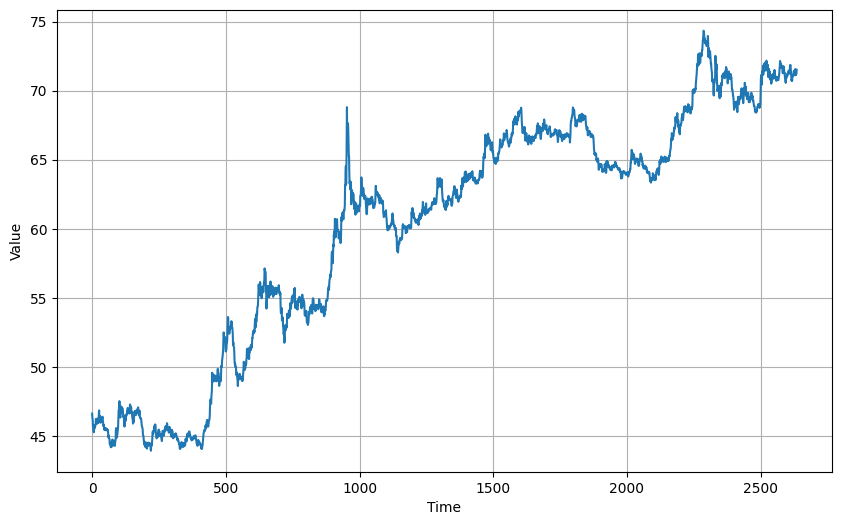

In [7]:
time_step = []
inr_conversion = []
with open(file_path, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        inr_conversion.append(float(row[2]))
        time_step.append(int(row[0]))
        
print(inr_conversion[len(time_step)-1])
series = np.array(inr_conversion)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 60
batch_size = 100
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecasttf.random.set_seed(51)

np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=120,
                             batch_size=100,
                             shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                         strides=1,padding="causal",
                         activation="relu",input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=51e-7, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

2024-05-23 12:30:49.903301: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2024-05-23 12:30:49.903348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: exp-1-57
2024-05-23 12:30:49.903355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: exp-1-57
2024-05-23 12:30:49.903427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 510.39.1
2024-05-23 12:30:49.903441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.85.12
2024-05-23 12:30:49.903446: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 525.85.12 does not match DSO version 510.39.1 -- cannot find working devices in this configuration


Epoch 1/500
19/19 [==============================] - 5s 132ms/step - loss: 33.9902 - mae: 34.4799
Epoch 2/500
19/19 [==============================] - 2s 114ms/step - loss: 6.0698 - mae: 6.5533
Epoch 3/500
19/19 [==============================] - 2s 114ms/step - loss: 4.3486 - mae: 4.8261
Epoch 4/500
19/19 [==============================] - 2s 114ms/step - loss: 3.4875 - mae: 3.9615
Epoch 5/500
19/19 [==============================] - 2s 114ms/step - loss: 3.2993 - mae: 3.7640
Epoch 6/500
19/19 [==============================] - 2s 114ms/step - loss: 3.0652 - mae: 3.5293
Epoch 7/500
19/19 [==============================] - 2s 115ms/step - loss: 3.0095 - mae: 3.4716
Epoch 8/500
19/19 [==============================] - 2s 114ms/step - loss: 2.8350 - mae: 3.2966
Epoch 9/500
19/19 [==============================] - 2s 114ms/step - loss: 2.6936 - mae: 3.1520
Epoch 10/500
19/19 [==============================] - 2s 113ms/step - loss: 2.6908 - mae: 3.1516
Epoch 11/500
19/19 [=================